# Dataset

In [1]:

#from lab 2
def split_set(dataset, key):
        # Sample on minimum amount of party data points
        minimum_amount = min(dataset[key].value_counts())
        print(minimum_amount)
        balanced_set = dataset.groupby(key,
                                        as_index = False,
                                        group_keys=False).apply(lambda s: s.sample(minimum_amount, replace=False))

        print(f'Subset size: {balanced_set.shape[0]}')
        return balanced_set

In [2]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

raw_df = pd.read_csv('GSDatabase.csv')
print(len(raw_df))
df_train, df_test = train_test_split(raw_df, test_size=0.2, stratify=raw_df['3-pt'])
df_val, df_test = train_test_split(df_test, test_size=0.5, stratify=df_test['3-pt'])
print(len(df_train))

if True:
    df_train = pd.read_csv('TrainingData.csv').set_index('Index')
    df_val = pd.read_csv('ValidationData.csv').set_index('Index')
    df_test = pd.read_csv('TestData.csv').set_index('Index')

undersampler = RandomUnderSampler()

balanced_set = split_set(df_train, '3-pt')

#balanced_train, blanced_val = train_test_split(balanced_set, test_size=0.2)
x_train = balanced_set['Text'].tolist()
y_train = balanced_set['3-pt'].tolist()
x_val = df_val['Text'].tolist()
y_val = df_val['3-pt'].tolist()
y_test = df_test['3-pt'].tolist()


4953
3962
949
Subset size: 2847


In [3]:
len(df_val)

495

In [4]:
# sanity check
class_0 = balanced_set[balanced_set['3-pt'] == 0]
class_1 = balanced_set[balanced_set['3-pt'] == 1]
class_2 = balanced_set[balanced_set['3-pt'] == 2]
print(len(class_0),len(class_1), len(class_2))

949 949 949


# Analysing data


In [5]:
import matplotlib.pyplot as plt
raw_df.head()

score = sorted(raw_df['Score'].unique())
counts = raw_df['Score'].value_counts().sort_index()
counts3 = raw_df['3-pt'].value_counts().sort_index()
print(counts, counts3)


Score
1.0       13
2.0      150
3.0      232
4.0      791
5.0      819
6.0      621
7.0      766
8.0     1185
9.0      344
10.0      32
Name: count, dtype: int64 3-pt
0    1186
1    1440
2    2327
Name: count, dtype: int64


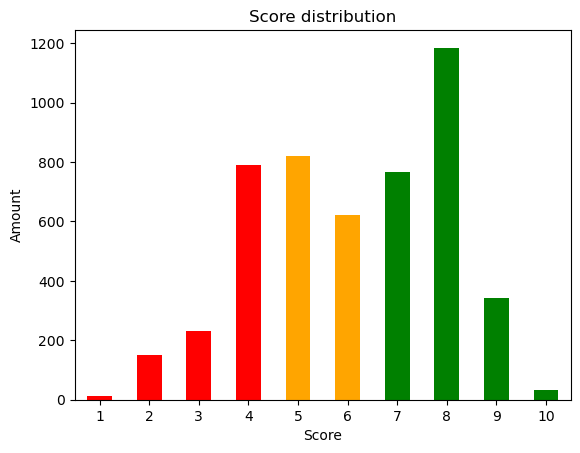

In [6]:
colors = ['red'] * 4 + ['orange'] * 2 + ['green'] * 4
bar_label = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
plot = counts.plot(kind='bar', color=colors)
plot.set_xticklabels(bar_label, rotation=0)
plt.ylabel('Amount')
plt.title('Score distribution')
plt.savefig('figures/scoreDistribution.pdf')


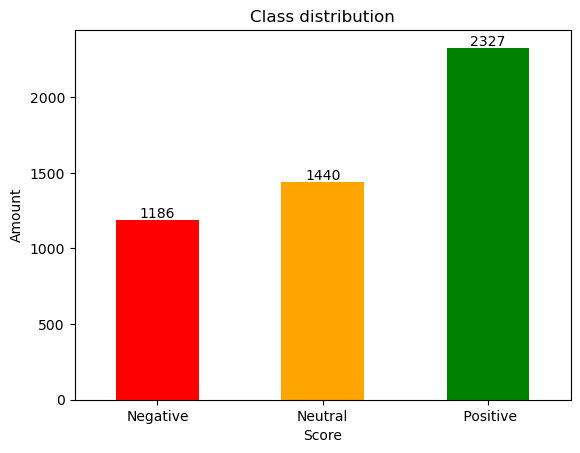

In [7]:
colors = ['red']  + ['orange']  + ['green'] 
bar_label = ['Negative', 'Neutral', ' Positive']
plt.title('Class distribution')

plot = counts3.plot(kind='bar', color=colors)
plt.xlabel('Score')
plt.ylabel('Amount')
plot.set_xticklabels(bar_label, rotation=0)

for p in plot.patches:
    plot.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()-50),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.savefig('figures/classDistribution.pdf')


In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import random
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", num_labels=3)

#analys amount of tokens
length_words = []
lengths_tokens = []

colors = []
for entry in raw_df.itertuples():
    txt = entry.Text
    output = tokenizer(txt)
    length_words.append(len(txt.split()))
    lengths_tokens.append(len(output.tokens()))
    class_ = entry._3
    if class_ == 0:
        color = 'Red'
    elif class_ == 1:
        color = 'Orange'
    elif class_ == 2:
        color = 'Green'
    colors.append(color)

#used used for nicer visulization
test = list(range(len(lengths_tokens)))
random.shuffle(test)


Token indices sequence length is longer than the specified maximum sequence length for this model (2068 > 512). Running this sequence through the model will result in indexing errors


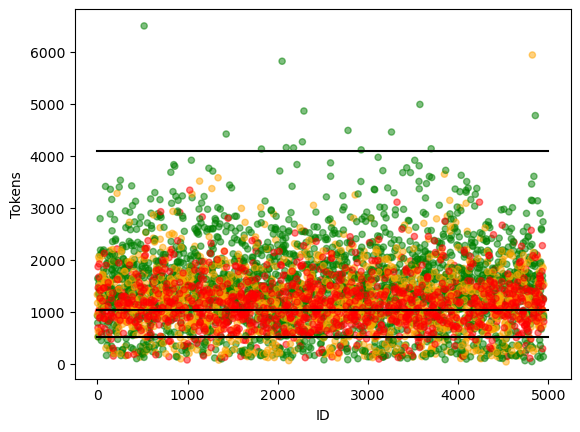

In [9]:
import matplotlib.pyplot as plt

plt.scatter(test, lengths_tokens, color=colors, marker='o', alpha=0.5, s = 20, label='Scatter Points')

plt.plot([0,5000],[512,512], color= 'black')
plt.plot([0,5000],[1024,1024], color= 'black')
plt.plot([0,5000],[4096,4096], color= 'black')
plt.xlabel('ID')
plt.ylabel('Tokens')
plt.title('')
plt.savefig('figures/wordTokenDistribution.pdf')

<BarContainer object of 4 artists>

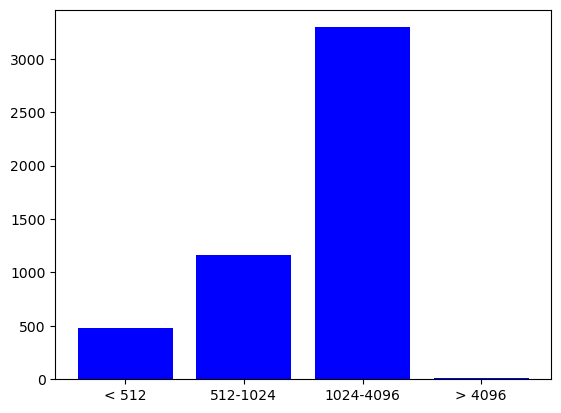

In [10]:
plt.scatter(length_words, lengths_tokens, color=colors, marker='o', alpha=0.5, s = 20, label='Scatter Points')
group_labels = ['< 512', '512-1024', '1024-4096', '> 4096']
groups = [512, 1024, 4096, float('inf')]  # Upper bounds

# Count the occurrences in each group
counts = [0,0,0,0]
for number in lengths_tokens:
    for i,group in enumerate(groups):
        if number < group:
            counts[i] += 1
            break
#counts = [sum(1 for number in lengths_tokens if number < group) for group in groups]

# Create a bar chart
plt.bar(group_labels, counts, color='blue')

# Models

In [12]:
# Method of splitting is based on: https://www.youtube.com/watch?v=yDGo9z_RlnE
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.nn import functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def convertTo512(txt, tokenizer, chunksize = 512):
    tokens = tokenizer.encode_plus(txt, return_tensors='pt', padding=True, truncation=True, add_special_tokens = True, return_attention_mask=True)
    input_id_splits = list(tokens['input_ids'][0].split(510))
    mask_splits = list(tokens['attention_mask'][0].split(510))
    
    for i in range(len(input_id_splits)):
        input_id_splits[i] = torch.cat([
            torch.Tensor([101]), input_id_splits[i], torch.Tensor([102])
        ])
        
        mask_splits[i] = torch.cat([
            torch.Tensor([1]), mask_splits[i], torch.Tensor([1])
        ])
        
        pad = chunksize - input_id_splits[i].shape[0]
        if pad > 0:
            input_id_splits[i] = torch.cat([
                input_id_splits[i], torch.Tensor([0] * pad)
            ])
            
            mask_splits[i] = torch.cat([
                mask_splits[i], torch.Tensor([0] * pad)
            ])
    
    return torch.stack(input_id_splits).to(device), torch.stack(mask_splits).to(device)




In [13]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
import numpy as np


class GamespotDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3).to(device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:

x_train_tokenize = tokenizer(x_train, max_length=512, padding=True, truncation=True, add_special_tokens = True)
x_val_tokenize = tokenizer(x_val, max_length=512, padding=True, truncation=True, add_special_tokens = True)

train_dataset = GamespotDataset(x_train_tokenize, y_train)

val_dataset = GamespotDataset(x_val_tokenize, y_val)


In [15]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred,average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [16]:
def get_prediction(df, model, tokenizer, max_length=512):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    preds = []
    for entry in df.itertuples():
        txt = entry.Text
        inputs = tokenizer.encode_plus(txt, return_tensors="pt", max_length=max_length, padding=True, truncation=True, add_special_tokens = True, return_attention_mask=True)
        inputs.to(device)
        output = model(**inputs)
        probs = F.softmax(output.logits, dim=-1)
        p = torch.argmax(probs).item()
        preds.append(p)
    return preds
        

In [17]:
def get_prediction_cool(df, model, tokenizer):
    model.to(device)
    preds = []
    for entry in df.itertuples():
        txt = entry.Text
        input_ids, mask = convertTo512(txt, tokenizer)
        input_dict = {
            'input_ids' : input_ids.long(),
            'attention_mask': mask.int()
        }
        output = model(**input_dict)
        probs = F.softmax(output.logits, dim=-1)
        mean = probs.mean(dim=0)
        #print(mean) #0,1,2
        preds.append(torch.argmax(mean).item())
    return preds


In [15]:
args = TrainingArguments(
    output_dir="BERT-finetuned", 
    evaluation_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    learning_rate=2e-5
)

trainer = Trainer(
    model=model,
    args = args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics 
)

In [ ]:
torch.cuda.empty_cache()
trainer.train()  

In [22]:
trainer.save_model()

In [45]:
loaded_model = AutoModelForSequenceClassification.from_pretrained("BERT-finetuned/")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", num_labels=3)
loaded_model.to(device)
torch.cuda.empty_cache()
preds = get_prediction(df_test, loaded_model, tokenizer)

In [46]:
torch.cuda.empty_cache()

In [47]:
from sklearn.metrics import classification_report

print(len(preds), len(preds))
print(classification_report(y_test, preds, target_names=['negative','neutral','positive'], digits=3))

496 496
              precision    recall  f1-score   support

    negative      0.580     0.639     0.608       119
     neutral      0.433     0.472     0.452       144
    positive      0.865     0.773     0.816       233

    accuracy                          0.653       496
   macro avg      0.626     0.628     0.625       496
weighted avg      0.671     0.653     0.661       496



In [50]:
preds_n512 = get_prediction_cool(df_test,loaded_model, tokenizer)

In [51]:
print(classification_report(y_test, preds_n512, target_names=['negative','neutral','positive'], digits=3))

              precision    recall  f1-score   support

    negative      0.605     0.605     0.605       119
     neutral      0.444     0.521     0.479       144
    positive      0.861     0.768     0.812       233

    accuracy                          0.657       496
   macro avg      0.636     0.631     0.632       496
weighted avg      0.678     0.657     0.666       496



# XLnet

In [ ]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm, trange
import torch

# Load pre-trained XLNet model and tokenizer
model_name = "xlnet-base-cased"
tokenizer = XLNetTokenizer.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)

texts = x_train
labels = y_train  

tokenized_texts = tokenizer(texts, max_length = 512, padding=True, truncation=True, return_tensors="pt").to(device)

labels = torch.tensor(labels).to(device)

dataset = TensorDataset(tokenized_texts["input_ids"], tokenized_texts["attention_mask"], labels)

batch_size = 12
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Set up training parameters
epochs = 4
learning_rate = 1e-5

optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training loop
for epoch in trange(epochs, desc="Outer Loop"):
    model.train()
    total_loss = 0
    i = 1
    for batch in dataloader:
        inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
        optimizer.zero_grad()
        #inputs.to(device)
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        print(str(i) + '/' + str(len(dataloader)))
        i += 1

    average_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss}")

# Save the trained model
model.save_pretrained("xl-finetuned")


In [36]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification
loaded_model = AutoModelForSequenceClassification.from_pretrained("xl-finetuned")

tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
loaded_model.to(device)

x_test = df_test['Text']
preds_xl = get_prediction(df_test, loaded_model, tokenizer, 512)
    

In [37]:
from sklearn.metrics import classification_report
val_xl = get_prediction(df_val, loaded_model, tokenizer, 512)
print(classification_report(y_val, val_xl, target_names=['negative','neutral','positive'], digits=3))

              precision    recall  f1-score   support

    negative      0.724     0.780     0.751       118
     neutral      0.580     0.576     0.578       144
    positive      0.853     0.824     0.838       233

    accuracy                          0.741       495
   macro avg      0.719     0.727     0.723       495
weighted avg      0.743     0.741     0.742       495



In [38]:

print(len(y_test),len(preds_xl))
print(classification_report(y_test, preds_xl, target_names=['negative','neutral','positive'], digits=3))

496 496
              precision    recall  f1-score   support

    negative      0.682     0.756     0.717       119
     neutral      0.612     0.569     0.590       144
    positive      0.883     0.871     0.877       233

    accuracy                          0.756       496
   macro avg      0.725     0.732     0.728       496
weighted avg      0.756     0.756     0.755       496



In [36]:
df_train.to_csv('TrainingData.csv')
df_val.to_csv('ValidationData.csv')
df_test.to_csv('TestData.csv')

# Longformer
Train model

In [104]:
from torch.utils.data import Dataset, DataLoader
from transformers import LongformerTokenizer, LongformerForSequenceClassification

tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
model = LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096', num_labels=3).to(device)

x_train_tokenize = tokenizer(x_train, max_length=1024, padding=True, truncation=True, add_special_tokens = True)
x_val_tokenize = tokenizer(x_val, max_length=1024, padding=True, truncation=True, add_special_tokens = True)

train_dataset = GamespotDataset(x_train_tokenize, y_train)

val_dataset = GamespotDataset(x_val_tokenize, y_val)


Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [20]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="longformer-finetuned", 
    evaluation_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    learning_rate=2e-5
)

trainer = Trainer(
    model=model,
    args = args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics 
)

In [ ]:
trainer.train()

In [22]:
trainer.save_model()

In [26]:
longformer_model = AutoModelForSequenceClassification.from_pretrained("longformer-finetuned/")
longformer_tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
longformer_model.to(device)
torch.cuda.empty_cache()
longformer_prediction4096 = get_prediction(df_test,longformer_model,longformer_tokenizer,4096)


In [27]:

from sklearn.metrics import classification_report
print(classification_report(y_test, longformer_prediction4096, target_names=['negative','neutral','positive'], digits=3))

              precision    recall  f1-score   support

    negative      0.691     0.714     0.702       119
     neutral      0.645     0.681     0.662       144
    positive      0.950     0.901     0.925       233

    accuracy                          0.792       496
   macro avg      0.762     0.765     0.763       496
weighted avg      0.799     0.792     0.795       496



In [28]:
torch.cuda.empty_cache()
longformer_prediction512 = get_prediction(df_test, longformer_model, longformer_tokenizer, 512)
print(classification_report(y_test, longformer_prediction512, target_names=['negative','neutral','positive'], digits=3))

              precision    recall  f1-score   support

    negative      0.703     0.597     0.645       119
     neutral      0.554     0.646     0.596       144
    positive      0.877     0.854     0.865       233

    accuracy                          0.732       496
   macro avg      0.711     0.699     0.702       496
weighted avg      0.741     0.732     0.734       496



# Evaluation

In [40]:
df_test, preds, preds_n512, longformer_prediction512, longformer_prediction4096, preds_xl

df_final = df_test

In [42]:
df_final['B512'] = preds
df_final['BN512'] = preds_n512
df_final['L512'] = longformer_prediction512
df_final['L4096'] = longformer_prediction4096
df_final['XLNet'] = preds_xl


In [43]:
neworder = ['Game', 'Score', '3-pt', 'B512', 'BN512', 'L512', 'L4096', 'XLNet', 'Text']
df_final = df_final[neworder]

In [44]:
df_final.to_csv('Predictions.csv')

# Manual work

In [19]:
df_p = pd.read_csv('Predictions.csv').set_index('Index')
lengths = []
for entry in df_p.itertuples():
    txt = entry.Text
    nr_of_words = len(txt.split())
    if nr_of_words < 75:
        print('Short:',entry.Index)
    elif nr_of_words > 2500:
        print('Long:',entry.Index)
    lengths.append(nr_of_words)

Short: 2097
Long: 101
Long: 753
Long: 498
Short: 1746
Short: 3492
Long: 2165
Short: 3039
Long: 170


In [53]:
df_p['Lengths'] = lengths
df_longest = df_p.sort_values('Lengths').tail(100)
df_shortest = df_p.sort_values('Lengths')[:100]

In [54]:
df_shortest

,Game,Score,3-pt,B512,BN512,L512,L4096,XLNet,Text,Lengths
Index,,,,,,,,,,
2097,NES Remix,6.0,1,1,1,1,1,1,"At $15, NES Remix is a pricey piece of pac...",45
1746,Call of Duty,8.0,2,2,2,2,2,2,"While far from perfect, Call of Duty is ex...",48
3492,Wumpus,4.0,0,1,0,1,1,1,What is a wumpus? A scary purple monster tha...,68
3039,Mystery Case Files: The Malgrave Incident,7.0,2,2,2,2,2,2,The Malgrave Incident can t...,68
1918,Sniper Elite III,6.0,1,0,0,0,0,0,All of this is assuming you'll even...,78
...,...,...,...,...,...,...,...,...,...,...
1369,The Walking Dead: Michonne - A Telltale Minise...,8.0,2,1,1,2,2,2,The fallout of the second episode is dealt wit...,584
4434,Arctic Thunder,4.0,0,1,1,1,0,1,"In 1999, Midway struck gold with its arcade-st...",585
4135,Pop,4.0,0,2,2,2,1,2,Pop is the dark avenue through which to unle...,589


In [ ]:
from sklearn.metrics import classification_report
temp = df_longest.drop('Game', axis=1).drop('Score', axis=1).drop('3-pt', axis=1).drop('Text', axis=1).drop('Lengths', axis=1)

for c in temp:
    print(c)
    print(classification_report(df_longest['3-pt'],df_longest[c]))

In [ ]:
from sklearn.metrics import classification_report
temp = df_shortest.drop('Game', axis=1).drop('Score', axis=1).drop('3-pt', axis=1).drop('Text', axis=1).drop('Lengths', axis=1)

for c in temp:
    print(c)
    print(classification_report(df_shortest['3-pt'],df_shortest[c]))

# Analysis of Agony

In [20]:
agony = df_p.loc[904]
agony['Text']

text = agony['Text']
first_paragraf = text[:599]

In [21]:
def pred_one(txt, model, tokenizer):
    model.to(device)
    inputs = tokenizer.encode_plus(txt, return_tensors="pt", max_length=512, padding=True, truncation=True, add_special_tokens = True, return_attention_mask=True)
    inputs.to(device)
    output = model(**inputs)
    probs = F.softmax(output.logits, dim=-1)
    print(probs)
    p = torch.argmax(probs).item()
    return p

In [22]:
first_paragraf

"Hell, by its very nature, shouldn't be enjoyed, but there's still something enthralling and entertaining in seeing creators imagine it in various ways. Agony, on the other hand, is less about Hell as a vehicle for entertainment or even fear. Agony's version of Hell is simply a place of unimaginable horror. It is depraved beyond reckoning, a place whose very brick and mortar is composed of atrocities. It is a place that never opens its sick, emaciated maw except to blaspheme and torment. Hell is terrifying in Agony, which goes hand in hand with the fact that the game is also torturous to play."

In [23]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification
bert_model = AutoModelForSequenceClassification.from_pretrained("BERT-finetuned/")
tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-cased", num_labels=3)
long_model = AutoModelForSequenceClassification.from_pretrained("longformer-finetuned/")
tokenizer_long = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
xl_model = AutoModelForSequenceClassification.from_pretrained("xl-finetuned/")
tokenizer_xl = XLNetTokenizer.from_pretrained('xlnet-base-cased')

b = pred_one(first_paragraf, bert_model, tokenizer_bert)
l = pred_one(first_paragraf, long_model, tokenizer_long)
x = pred_one(first_paragraf, xl_model, tokenizer_xl)
print(b,l,x)


NameError: name 'LongformerTokenizer' is not defined

In [109]:
b = pred_one(text, bert_model, tokenizer_bert)
l = pred_one(text, long_model, tokenizer_long)
x = pred_one(text, xl_model, tokenizer_xl)
print(b,l,x)

tensor([[0.0817, 0.5769, 0.3415]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[2.4992e-04, 1.0547e-03, 9.9870e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0.5251, 0.3507, 0.1242]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1 2 0


# Analysis of Loot Rascal

In [169]:
LootRascal = df_p.loc[1177]
LootRascal['Text']
text = LootRascal['Text']
second_part = text[-972:]

In [170]:
second_part

"Loot Rascal's simplicity ends up weakening its prospects as a long-term time investment and it’s not the kind of game that leaves you feeling like you’ve learned much from your losses. The only progress that carries over between playthroughs depends on the kindness of other players: when you die, the enemy that kills you can snatch one of your cards, and if another player encounters that enemy in their game and vanquishes the foe, they can choose to return that card to you, lest their game be haunted by your vengeful ghost.Loot Rascals card and deck systems are enticing, and its singular aesthetic and strange sense of humor make the game fundamentally likable early on. After a few hours, however, it feels like there isn't a lot to gain for all the effort you're asked to put in. There are fleeting moments of joy when a strategic card collection lets you steamroll through the enemy forces, but the monotony of getting to those moments wears you down in the end."

In [123]:
tokens = tokenizer.encode(text, max_length=512, padding=True, truncation=True, add_special_tokens = True)
tokenizer.decode(tokens)

"<s>The opening cutscene of Loot Rascals, largely narrated by a teapot-headed British spaceman, establishes the game’s strange tone well. Instead of arriving at a holiday-resort planet to restore a medical unit's antenna as intended, you crash on an alien moon and find yourself battling against the game’s eponymous “rascals” that have stolen the medical unit. To get it back, you’ll need to trek through five randomly generated levels, battling or avoiding the moon’s many aggressors.Loot Rascals is wacky in a way that feels genuine; the art style and creature design in particular feel like the work of artists who watched a lot of The Ren &amp; Stimpy Show as kids and soaked up its playful grotesquery.The action in Loot Rascals unfolds in a turn-based fashion. You move between hexagonal spaces, uncovering each area as you go, and either fight or circumvent enemies you encounter. Your goal is to find the warp spaces in each zone and make it to the fifth level to escape. Your attack and def

In [124]:
b = pred_one(text, bert_model, tokenizer_bert)
l = pred_one(text, long_model, tokenizer_long)
x = pred_one(text, xl_model, tokenizer_xl)
print(b,l,x)

tensor([[0.0048, 0.0549, 0.9403]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[2.1635e-04, 1.9258e-03, 9.9786e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([[0.0074, 0.1920, 0.8006]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
2 2 2


In [171]:
b = pred_one(second_part, bert_model, tokenizer_bert)
l = pred_one(second_part, long_model, tokenizer_long)
x = pred_one(second_part, xl_model, tokenizer_xl)
print(b,l,x)

tensor([[0.0093, 0.4500, 0.5407]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.0024, 0.9962, 0.0014]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.0808, 0.8759, 0.0434]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
2 1 1


# Adding Global mask

In [24]:
# Kolla på några failade och lägg till global attention på dom
# 512 och 4096

df_p
df_temp = df_p
idx = []
for entry in df_p.itertuples():
    keep = False
    if entry._3 != entry.L4096 and entry._3 != entry.L512 :
        keep = True

    if not keep:
        idx.append(entry.Index)
        
df_temp = df_temp.drop(idx)

In [25]:
df_random = df_temp.sample(n=10)
df_random

,Game,Score,3-pt,B512,BN512,L512,L4096,XLNet,Text
Index,,,,,,,,,
4122,Steel Horizon,4.0,0,1,1,1,1,0,"Earlier this year, Konami released Steel Hor..."
753,Kingdom Hearts III,8.0,2,1,1,1,1,2,The only way to really understand the emotions...
3499,The Sims 3,8.0,2,1,1,1,1,1,"By comparison, the rest of daily sims lif..."
828,The Bard's Tale IV: Barrows Deep,4.0,0,1,1,1,1,1,InXile Entertainment's resurrection of this lo...
565,Kingdom Hearts III,4.0,0,1,1,1,1,1,Kingdom Hearts 3 Re:Mind's title doesn't lie. ...
2783,Choplifter HD,6.0,1,2,2,2,2,2,"Avoiding hostage deaths, taking out fo..."
1918,Sniper Elite III,6.0,1,0,0,0,0,0,All of this is assuming you'll even...
1787,LEGO Batman 3: Beyond Gotham,7.0,2,1,1,1,1,1,"The Dark Knight Returns, and also the gray..."
904,Agony,3.0,0,1,1,2,1,0,"Hell, by its very nature, shouldn't be enjoyed..."


In [40]:
def get_prediction_global(df, model, tokenizer, max_length=512, tokenRange=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    preds = []
    for entry in df.itertuples():
        txt = entry.Text
        inputs = tokenizer.encode_plus(txt, return_tensors="pt", max_length=max_length, padding=True, truncation=True, add_special_tokens = True, return_attention_mask=True)
        inputs.to(device)
        gam = torch.ones_like(inputs["input_ids"])
        gam[:, :-tokenRange] = 0 #only last XX is global
        output = model(**inputs, global_attention_mask=gam)
        probs = F.softmax(output.logits, dim=-1)
        p = torch.argmax(probs).item()
        preds.append(p)
    return preds

SyntaxError: non-default argument follows default argument (1039271603.py, line 1)

In [35]:
torch.cuda.empty_cache()

In [36]:
from transformers import LongformerTokenizer
longformer_model = AutoModelForSequenceClassification.from_pretrained("longformer-finetuned/")
longformer_tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
longformer_model.to(device)


pred_4096_global = get_prediction_global(df_p, longformer_model,longformer_tokenizer, 4096, 25)
pred_512_global = get_prediction_global(df_p, longformer_model,longformer_tokenizer, 512, 25)

In [39]:
from sklearn.metrics import classification_report
print(classification_report(df_p['3-pt'],pred_512_global,target_names=['negative','neutral','positive'], digits=3))
print(classification_report(df_p['3-pt'],pred_4096_global, target_names=['negative','neutral','positive'], digits=3))

              precision    recall  f1-score   support

    negative      0.696     0.597     0.643       119
     neutral      0.508     0.625     0.561       144
    positive      0.871     0.811     0.840       233

    accuracy                          0.706       496
   macro avg      0.692     0.678     0.681       496
weighted avg      0.724     0.706     0.712       496

              precision    recall  f1-score   support

    negative      0.718     0.706     0.712       119
     neutral      0.574     0.646     0.608       144
    positive      0.899     0.837     0.867       233

    accuracy                          0.750       496
   macro avg      0.730     0.730     0.729       496
weighted avg      0.761     0.750     0.754       496

